In [1]:
## Importing the necessary packages and libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, warnings
import datetime as dt
import string
from collections import Counter
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import csv

In [2]:
#Reading the csv dataset using pandas
rfm = pd.read_csv(r'Downloads\data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})
rfm

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12-09-2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12-09-2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12-09-2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12-09-2011 12:50,4.15,12680,France


In [3]:
#DATA PREPROCESSING
## --> Dataset has null values in 'Description' and 'CustomerID' columns.
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [4]:
# Since the 'invoice date' is of object data type, it has to be converted to 'datetime'
rfm['InvoiceDate'] = pd.to_datetime(rfm['InvoiceDate'])

In [5]:
# Creating two new fields for 'Date' and 'Time' from the 'invoice date' timestamp
rfm['Date'] = rfm['InvoiceDate'].dt.strftime('%Y-%m-%d')
rfm['Time'] = rfm['InvoiceDate'].dt.strftime('%H:%M')
rfm['Date'] = pd.to_datetime(rfm['Date'])

In [6]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  object        
 7   Country      541909 non-null  object        
 8   Date         541909 non-null  datetime64[ns]
 9   Time         541909 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 41.3+ MB


In [7]:
max(rfm['Date'])

Timestamp('2011-12-09 00:00:00')

In [8]:
# Drpped the rows having null values in 'CustomerID' column.
# Dropped the rows having duplicates in 'InvoiceNo' and 'Stockcode' (Since a customer cannot have the same stockcode more than once for one InvoiceID)
rfm_df = rfm.drop("InvoiceDate" ,  axis = 'columns')
rfm_df = rfm_df.dropna(subset = ['CustomerID' , 'Description'])
rfm_df = rfm_df.drop_duplicates(subset = ['InvoiceNo' , 'StockCode'])
# Created a new field 'Total Price' by calculating the total revenue garnered by a customer 
rfm_df['Total Price'] = rfm_df['Quantity']*rfm_df['UnitPrice']
rfm_df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Total Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12-01,08:26,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01,08:26,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12-01,08:26,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01,08:26,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01,08:26,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,2011-12-09,12:50,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,2011-12-09,12:50,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,2011-12-09,12:50,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,2011-12-09,12:50,16.60


In [9]:
rfm_df.to_csv('rfm_dataset.csv' , index =False)

In [10]:
# Grouping the dataset by 'Description' to calculate the count of unique stockcodes for each product 
rfm_df_stock_group = rfm_df.groupby('Description').agg({'StockCode' : 'nunique'})
rfm_df_stock_group = pd.DataFrame(rfm_df_stock_group)
rfm_df_stock_group

,StockCode
Description,
4 PURPLE FLOCK DINNER CANDLES,1
50'S CHRISTMAS GIFT BAG LARGE,1
DOLLY GIRL BEAKER,1
I LOVE LONDON MINI BACKPACK,1
I LOVE LONDON MINI RUCKSACK,1
...,...
ZINC T-LIGHT HOLDER STARS SMALL,1
ZINC TOP 2 DOOR WOODEN SHELF,1
ZINC WILLIE WINKIE CANDLE STICK,1


In [18]:
# Filtering the dataset to only retrieve rows having quantity and total price greater than zero
rfm_df = rfm_df[rfm_df['Quantity'] > 0]
rfm_df = rfm_df[rfm_df['Total Price'] > 0]
rfm_df

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Total Price


In [19]:
# Grouping the dataset by 'CustomerID' , 'InvoiceNo' ,'Description' , 'Date' to calculate the total quantity and stockcodes for each product 
rfm_df_new = rfm_df.groupby(['CustomerID' , 'InvoiceNo' , 'Description' , 'Date']).agg({'Quantity': 'sum', 'StockCode' : 'count'})
rfm_df_new 

,,,,Quantity,StockCode
CustomerID,InvoiceNo,Description,Date,,


In [15]:
# Created a new field to store the number of days indicating the customers who made the most recent purchase
single_date = pd.to_datetime('2012-01-01')
rfm_df['min_days'] = single_date -  rfm_df['Date']
rfm_df


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Time,Total Price,min_days
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12-01,08:26,15.30,396 days
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01,08:26,20.34,396 days
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12-01,08:26,22.00,396 days
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01,08:26,20.34,396 days
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01,08:26,20.34,396 days
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,12680,France,2011-12-09,12:50,10.20,23 days
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,12680,France,2011-12-09,12:50,12.60,23 days
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,12680,France,2011-12-09,12:50,16.60,23 days
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,12680,France,2011-12-09,12:50,16.60,23 days


In [16]:
# Grouping the dataset by 'CustomerID' to calculate the recency , frequency and total revenue generated by the customer
rfm_df_count = rfm_df.groupby(['CustomerID' ]).agg({ 'min_days' : 'min', 'InvoiceNo' : 'nunique' , 'Total Price': 'sum' , })
rfm_df_count = rfm_df_count.rename(columns = {'min_days' : 'R' , 'InvoiceNo' : 'F' , 'Total Price' : 'M'})
rfm_df_count

,R,F,M
CustomerID,,,
12346,348 days,1,77183.60
12347,25 days,7,4310.00
12348,98 days,4,1595.64
12349,41 days,1,1757.55
12350,333 days,1,334.40
...,...,...,...
18280,300 days,1,180.60
18281,203 days,1,80.82
18282,30 days,2,178.05


In [17]:
# Maximum frequency , monetary and most recent purchase
frequency = rfm_df_count['F'].max()
monetary = rfm_df_count['M'].max()
recency = rfm_df_count['R'].min()
print(f'{frequency} , {monetary} , {recency}' )

209 , 280206.02 , 23 days 00:00:00


In [18]:
# Converted the 'R' (str) to integer
# RFM dataset
rfm_df_count['R'] = rfm_df_count['R'].astype(str).str.extract('(\d+)').astype(int)
rfm_df_count

,R,F,M
CustomerID,,,
12346,348,1,77183.60
12347,25,7,4310.00
12348,98,4,1595.64
12349,41,1,1757.55
12350,333,1,334.40
...,...,...,...
18280,300,1,180.60
18281,203,1,80.82
18282,30,2,178.05


In [19]:
rfm_df_count.to_csv('rfm_count_dataset.csv' , index=False)

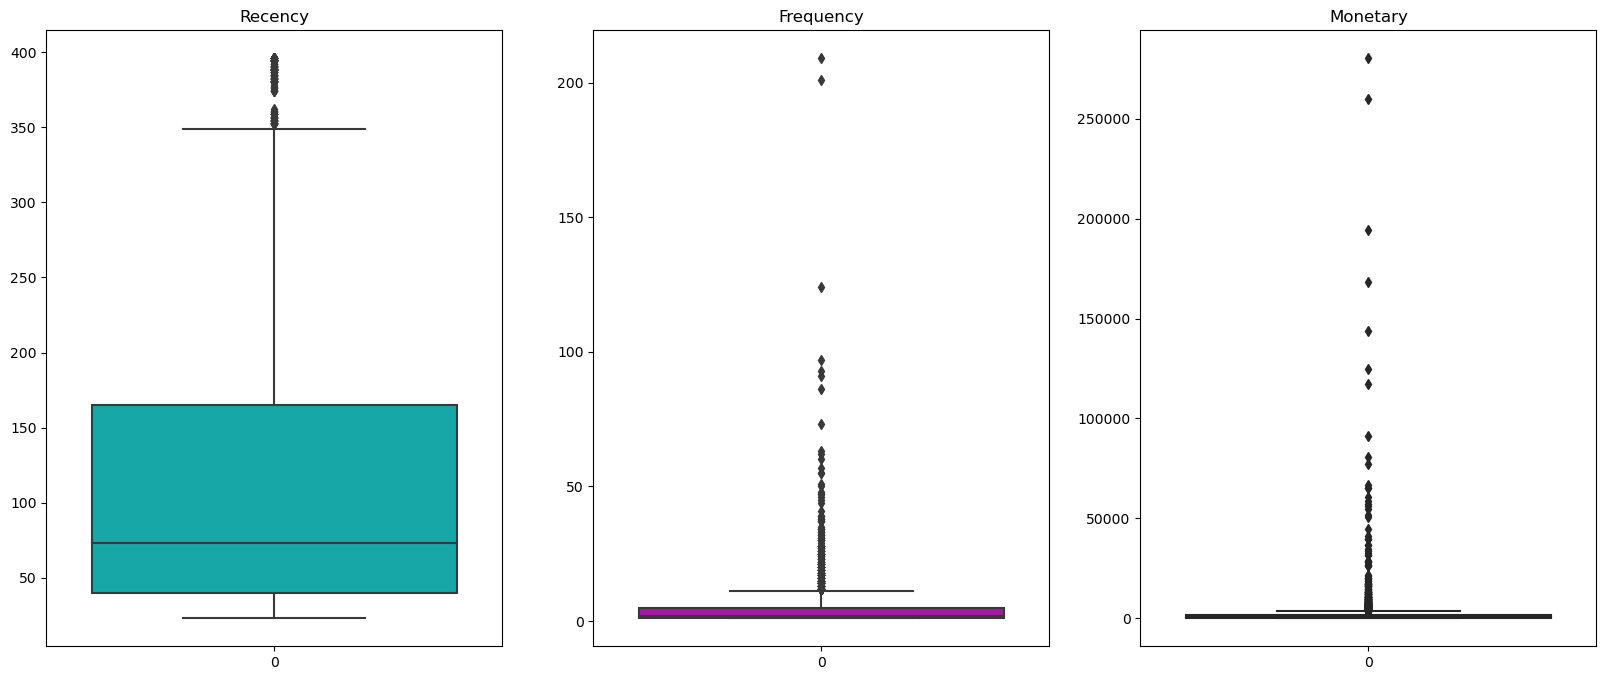

In [20]:
#Inter-quantile range
# Box-plots for recency , frequency and monetary 
fig , ax = plt.subplots(1,3, figsize = (20,8))
sns.boxplot(rfm_df_count['R'] , ax = ax[0] , color = 'c')
sns.boxplot(rfm_df_count['F'] , ax = ax[1] , color = 'm')
sns.boxplot(rfm_df_count['M'] , ax = ax[2] , color = 'g')
ax[0].set_title('Recency')
ax[1].set_title('Frequency')
ax[2].set_title('Monetary')
plt.show()

In [21]:
# Statistical summary of the RFM dataset
# The dataset is highly positively skewed for recency , frequency and monetary componenets since the mean is greater than median
rfm_df_count.describe()

,R,F,M
count,4338.000000,4338.000000,4338.000000
mean,115.059474,4.271784,2038.840837
std,100.012264,7.697751,8976.543627
min,23.000000,1.000000,3.750000
25%,40.000000,1.000000,305.145000
50%,73.000000,2.000000,658.760000
75%,164.750000,5.000000,1647.905000
max,396.000000,209.000000,280206.020000


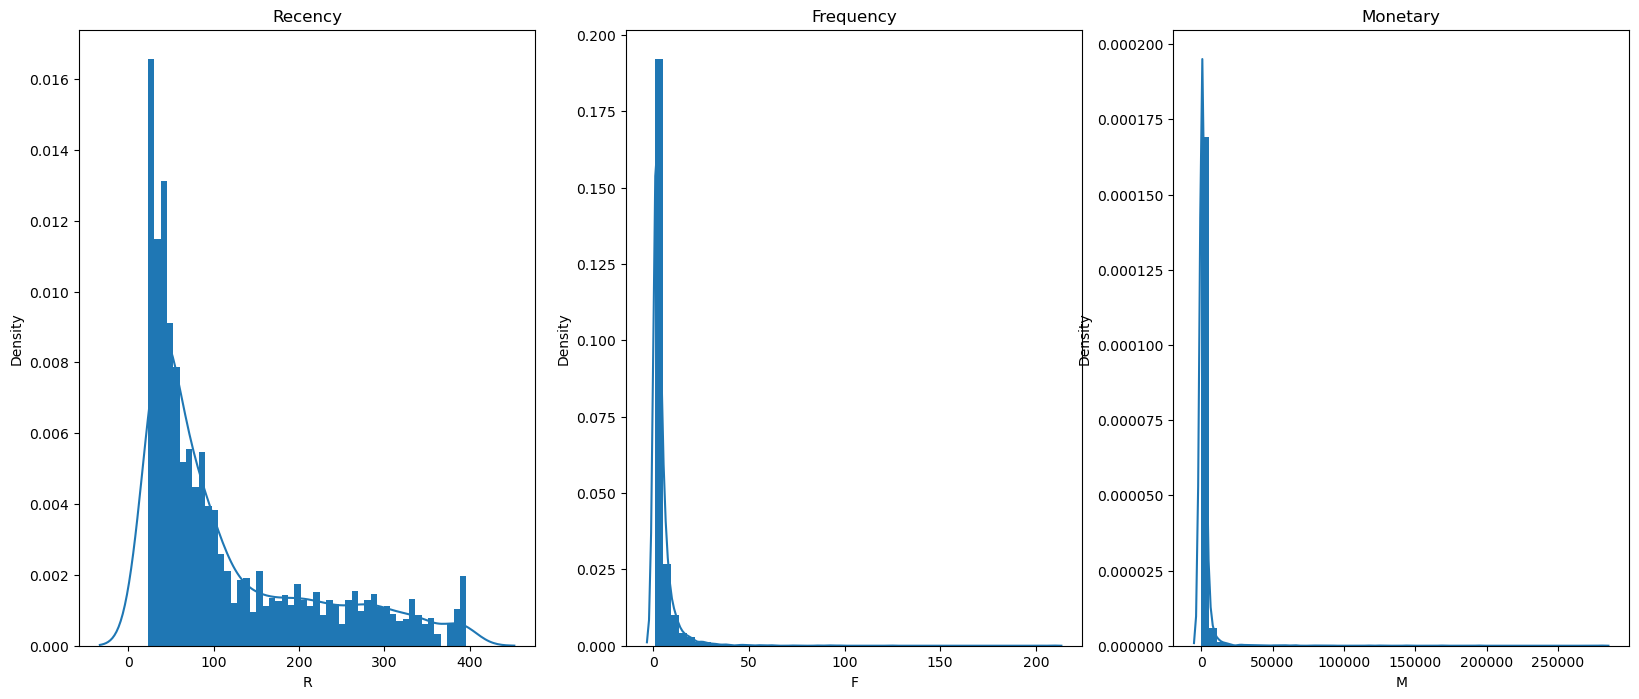

In [22]:
# Statistical plots to confirm skewness
# The dataset is highly positively skewed for recency , frequency and monetary componenets since the mean is greater than median
# Postive skewness --> The majority of data points are concentrated on the left side (lower values) of the distribution.
# Negative skweness --> The majority of data points are concentrated on the right side (higher values) of the distribution.
fig , ax = plt.subplots(1,3,figsize = (20,8))
pdc = sns.distplot(rfm_df_count['R'],
                  bins=50,
                  kde=True,
                  ax = ax[0],
                  hist_kws={"linewidth": 20,'alpha':1})
pdc = sns.distplot(rfm_df_count['F'],
                  bins=50,
                  kde=True,
                  ax = ax[1],
                  hist_kws={"linewidth": 20,'alpha':1})
pdc = sns.distplot(rfm_df_count['M'],
                  bins=50,
                  kde=True,
                  ax = ax[2],
                  hist_kws={"linewidth": 20,'alpha':1})
ax[0].set_title('Recency')
ax[1].set_title('Frequency')
ax[2].set_title('Monetary')

#pdc.set(xlabel='Normal Distribution', ylabel='Frequency')
 
plt.show()

In [23]:
# Normalized the dataset and minimized skewness by scaling using 'logarthmic' transformation
rfm_df_scaled = np.log(rfm_df_count)
rfm_df_scaled = pd.DataFrame(rfm_df_scaled , columns = ['R' , 'F' , 'M'])
rfm_df_scaled

,R,F,M
CustomerID,,,
12346,5.852202,0.000000,11.253942
12347,3.218876,1.945910,8.368693
12348,4.584967,1.386294,7.375030
12349,3.713572,0.000000,7.471676
12350,5.808142,0.000000,5.812338
...,...,...,...
18280,5.703782,0.000000,5.196285
18281,5.313206,0.000000,4.392224
18282,3.401197,0.693147,5.182064


In [24]:
rfm_df_scaled.describe()

,R,F,M
count,4338.000000,4338.000000,4338.000000
mean,4.396322,0.944463,6.578033
std,0.829696,0.900770,1.263162
min,3.135494,0.000000,1.321756
25%,3.688879,0.000000,5.720787
50%,4.290459,0.693147,6.490359
75%,5.104426,1.609438,7.407260
max,5.981414,5.342334,12.543280


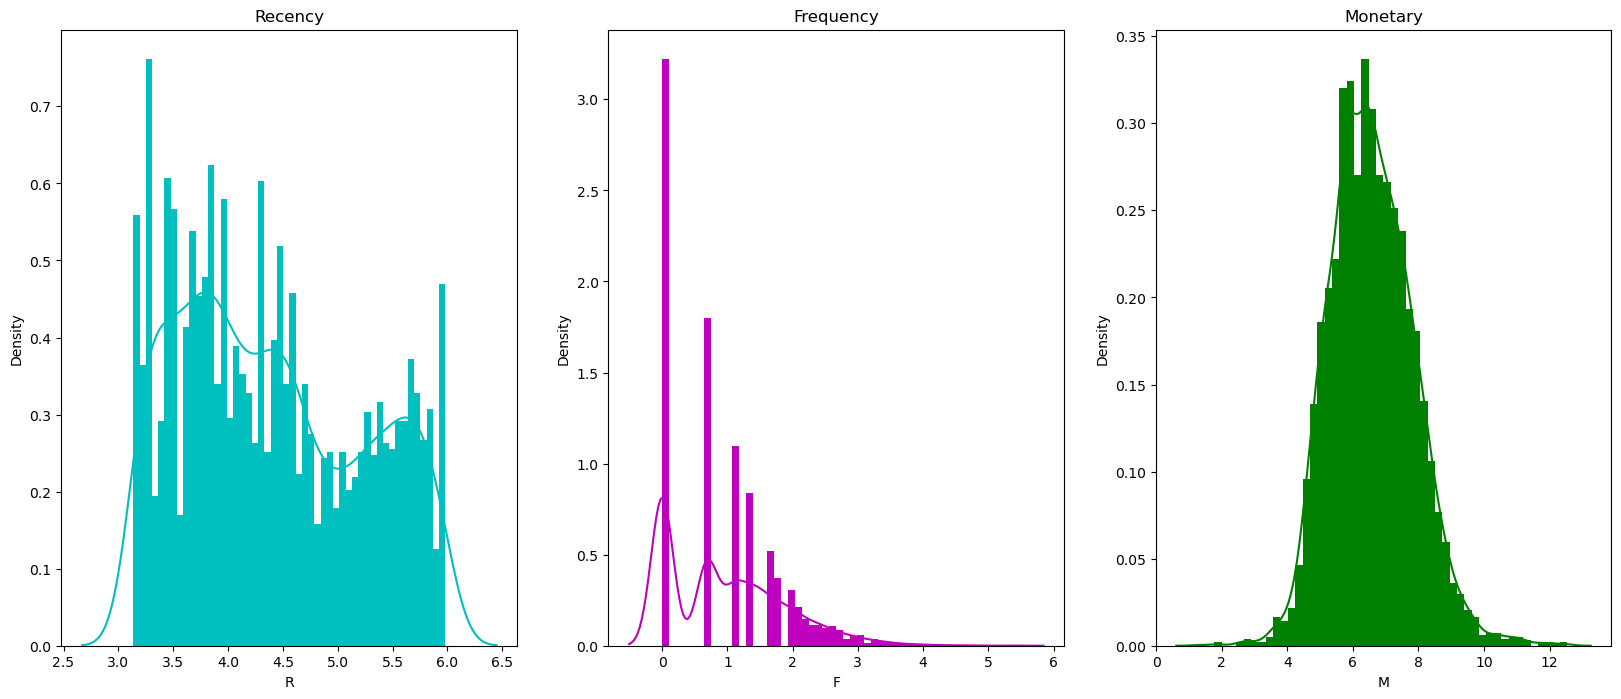

In [25]:
fig , ax = plt.subplots(1,3,figsize = (20,8))
pdc = sns.distplot(rfm_df_scaled['R'],
                  bins=50,
                  kde=True,
                  ax = ax[0],
                  color = 'c',
                  hist_kws={"linewidth": 20,'alpha':1})
pdc = sns.distplot(rfm_df_scaled['F'],
                  bins=50,
                  kde=True,
                  ax = ax[1],
                  color = 'm',
                  hist_kws={"linewidth": 20,'alpha':1})
pdc = sns.distplot(rfm_df_scaled['M'],
                  bins=50,
                  kde=True,
                  ax = ax[2],
                  color = 'g',
                  hist_kws={"linewidth": 20,'alpha':1})
ax[0].set_title('Recency')
ax[1].set_title('Frequency')
ax[2].set_title('Monetary')

#pdc.set(xlabel='Normal Distribution', ylabel='Frequency')
 
plt.show()


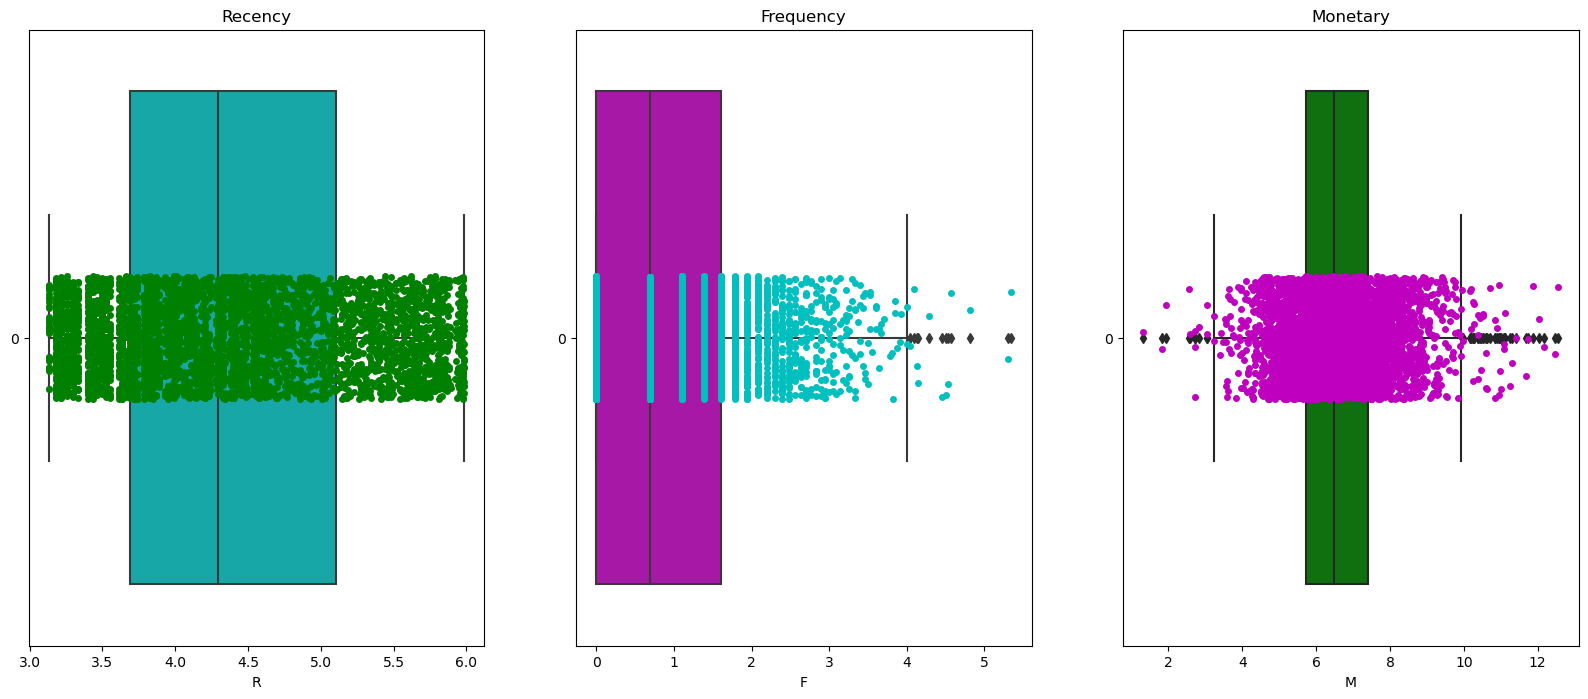

In [26]:
fig , ax = plt.subplots(1,3, figsize = (20,8))
sns.boxplot(rfm_df_scaled['R'] , ax = ax[0] , color = 'c' , orient = 'h')
sns.stripplot(rfm_df_scaled['R'] , ax= ax[0] , color = 'g' , orient = 'h')
sns.boxplot(rfm_df_scaled['F'] , ax = ax[1] , color = 'm' , orient = 'h')
sns.stripplot(rfm_df_scaled['F'] , ax= ax[1] , color = 'c', orient = 'h')
sns.boxplot(rfm_df_scaled['M'] , ax = ax[2] , color = 'g', orient = 'h')
sns.stripplot(rfm_df_scaled['M'] , ax = ax[2] , color = 'm' , orient = 'h')
ax[0].set_title('Recency')
ax[1].set_title('Frequency')
ax[2].set_title('Monetary')
plt.show()

In [27]:
rfm_df_scaled

,R,F,M
CustomerID,,,
12346,5.852202,0.000000,11.253942
12347,3.218876,1.945910,8.368693
12348,4.584967,1.386294,7.375030
12349,3.713572,0.000000,7.471676
12350,5.808142,0.000000,5.812338
...,...,...,...
18280,5.703782,0.000000,5.196285
18281,5.313206,0.000000,4.392224
18282,3.401197,0.693147,5.182064


In [28]:
rfm_scores = rfm_df_scaled.copy()
rfm_scores

,R,F,M
CustomerID,,,
12346,5.852202,0.000000,11.253942
12347,3.218876,1.945910,8.368693
12348,4.584967,1.386294,7.375030
12349,3.713572,0.000000,7.471676
12350,5.808142,0.000000,5.812338
...,...,...,...
18280,5.703782,0.000000,5.196285
18281,5.313206,0.000000,4.392224
18282,3.401197,0.693147,5.182064


In [29]:
# Employed Quartile based method to estimate the 25th , 50th, 75th ,100th quartile values
def quartiles_name(val , quartile_name):
    rfm_score = rfm_scores.sort_values(by = [val] , ascending = True)
    rfm_score

    quartile_1 = round((rfm_score[val].count() + 1)/4 , 0).astype(int)
    quartile_2 = round((rfm_score[val].count() + 1)/2 , 0).astype(int)
    quartile_3 = round(3*(rfm_score[val].count() + 1)/4 , 0).astype(int)
    quartile_4 = (rfm_score[val].count() - 1)

    dict_quartile = {}
    dict_quartile['Q1'] = quartile_1
    dict_quartile['Q2'] = quartile_2
    dict_quartile['Q3'] = quartile_3
    dict_quartile['Q4'] = quartile_4
    dict_quartile

    dict_pos = {}
    dict_pos['Q1'] = rfm_score[val][quartile_1]
    dict_pos['Q2'] = rfm_score[val][quartile_2]
    dict_pos['Q3'] = rfm_score[val][quartile_3]
    dict_pos['Q4'] = rfm_score[val][quartile_4]

    dict_pos

    index = [quartile_name]
    quartile_df = pd.DataFrame(dict_pos , index = index )
    quartile_df  = quartile_df .T
    quartile_df  = quartile_df .reset_index()
    return quartile_df 

In [30]:
recency_df = quartiles_name('R' , 'recency')

In [31]:
frequency_df = quartiles_name('F' , 'frequency')

In [32]:
monetary_df = quartiles_name('M' , 'monetary')

In [33]:
quartile = pd.merge(recency_df , frequency_df , on = 'index')
quartiles = pd.merge(quartile , monetary_df , on = 'index')
quartiles = quartiles.set_index('index')
quartiles

,recency,frequency,monetary
index,,,
Q1,3.688879,0.000000,5.721229
Q2,4.290459,0.693147,6.491194
Q3,5.105945,1.609438,7.408227
Q4,5.981414,5.342334,12.543280


In [34]:
rfm_df_apply = rfm_df_scaled.copy()
rfm_df_apply

,R,F,M
CustomerID,,,
12346,5.852202,0.000000,11.253942
12347,3.218876,1.945910,8.368693
12348,4.584967,1.386294,7.375030
12349,3.713572,0.000000,7.471676
12350,5.808142,0.000000,5.812338
...,...,...,...
18280,5.703782,0.000000,5.196285
18281,5.313206,0.000000,4.392224
18282,3.401197,0.693147,5.182064


In [35]:
#Assign RFM Score range for recency, frequency and monetary values
# 4- most recent , high frequency  , high monetary 
def R_Score(r , q):
    if r <= q[0]:
        return 4
    elif r <= q[1]:
        return 3
    elif r <= q[2]:
        return 2
    else:
        return 1
    
def FM_Score(r , q):
    if r <= q[0]:
        return 1
    elif r <= q[1]:
        return 2
    elif r <= q[2]:
        return 3
    else:
        return 4


In [36]:
#Apply the functions to calculate RFM score
rfm_df_apply['recency'] = rfm_df_apply['R'].apply(lambda r: R_Score(r, quartiles['recency']))
rfm_df_apply['frequency'] = rfm_df_apply['F'].apply(lambda r: FM_Score(r, quartiles['frequency']))
rfm_df_apply['monetary'] = rfm_df_apply['M'].apply(lambda r: FM_Score(r, quartiles['recency']))

In [37]:
rfm_assigned_score = rfm_df_apply.copy()
rfm_assigned_score.drop(columns = ['R' , 'F' , 'M'] , inplace = True)
rfm_assigned_score


,recency,frequency,monetary
CustomerID,,,
12346,1,1,4
12347,4,4,4
12348,2,3,4
12349,3,1,4
12350,1,1,4
...,...,...,...
18280,1,1,4
18281,1,1,3
18282,4,2,4


In [38]:
rfm_df_scaled_score = pd.merge(rfm_df_scaled , rfm_assigned_score , on = 'CustomerID')
rfm_df_scaled_score
rfm_df_unscaled = pd.merge(rfm_df_count , rfm_assigned_score , on = 'CustomerID')
rfm_df_unscaled

,R,F,M,recency,frequency,monetary
CustomerID,,,,,,
12346,348,1,77183.60,1,1,4
12347,25,7,4310.00,4,4,4
12348,98,4,1595.64,2,3,4
12349,41,1,1757.55,3,1,4
12350,333,1,334.40,1,1,4
...,...,...,...,...,...,...
18280,300,1,180.60,1,1,4
18281,203,1,80.82,1,1,3
18282,30,2,178.05,4,2,4


In [39]:
# Assigned labelled categories to the RFM scores
recency_bins = [0,1,2,3,4]
frequency_bins = [0,1,2,3,4]
monetary_bins = [0,1,2,3,4]
recency_label = ['Lapsed customer' , 'Dormant customer' , 'Recent customer' , 'Most Recent customer']
frequency_label = ['Infrequent shoppers' , 'Occasional shoppers' , 'Frequent shoppers' , 'Loyal shoppers']
monetary_label = ['Marginal-value customer' , 'Low-value customer' , 'Medium-value customer' , 'High-value customer']
rfm_assigned_score['recency_label'] = pd.cut(rfm_assigned_score['recency'] , bins = recency_bins , labels = recency_label )
rfm_assigned_score['frequency_label'] = pd.cut(rfm_assigned_score['frequency'] , bins = frequency_bins , labels = frequency_label )
rfm_assigned_score['monetary_label'] = pd.cut(rfm_assigned_score['monetary'] , bins = monetary_bins , labels = monetary_label )
rfm_assigned_score

,recency,frequency,monetary,recency_label,frequency_label,monetary_label
CustomerID,,,,,,
12346,1,1,4,Lapsed customer,Infrequent shoppers,High-value customer
12347,4,4,4,Most Recent customer,Loyal shoppers,High-value customer
12348,2,3,4,Dormant customer,Frequent shoppers,High-value customer
12349,3,1,4,Recent customer,Infrequent shoppers,High-value customer
12350,1,1,4,Lapsed customer,Infrequent shoppers,High-value customer
...,...,...,...,...,...,...
18280,1,1,4,Lapsed customer,Infrequent shoppers,High-value customer
18281,1,1,3,Lapsed customer,Infrequent shoppers,Medium-value customer
18282,4,2,4,Most Recent customer,Occasional shoppers,High-value customer


In [40]:
# Assigned weights to the recency,frequency and monetary to calculate the weighted score by combining RFM values
weight_recency = 1
weight_frequency = 2 
weight_monetary =  3
rfm_assigned_score['Score_assigned'] = (weight_recency*rfm_assigned_score['recency'] + weight_frequency*rfm_assigned_score['frequency'] + weight_monetary*rfm_assigned_score['monetary'])

rfm_assigned_score

,recency,frequency,monetary,recency_label,frequency_label,monetary_label,Score_assigned
CustomerID,,,,,,,
12346,1,1,4,Lapsed customer,Infrequent shoppers,High-value customer,15
12347,4,4,4,Most Recent customer,Loyal shoppers,High-value customer,24
12348,2,3,4,Dormant customer,Frequent shoppers,High-value customer,20
12349,3,1,4,Recent customer,Infrequent shoppers,High-value customer,17
12350,1,1,4,Lapsed customer,Infrequent shoppers,High-value customer,15
...,...,...,...,...,...,...,...
18280,1,1,4,Lapsed customer,Infrequent shoppers,High-value customer,15
18281,1,1,3,Lapsed customer,Infrequent shoppers,Medium-value customer,12
18282,4,2,4,Most Recent customer,Occasional shoppers,High-value customer,20


In [41]:
# Assigned labelled categories to the Combined RFM scores
segment_bins = [0,6,12,20,24]
segment_labels = ['Bronze customer group' , 'Silver customer group' , 'Gold customer group' , 'Platinum customer group']
rfm_assigned_score['Customer_segment_label'] =  pd.cut(rfm_assigned_score['Score_assigned'] , bins = segment_bins , labels = segment_labels)
rfm_assigned_score = rfm_assigned_score.reset_index()

In [42]:
#Statistical measures to gain insights into customer labels
rfm_group_bar_by_segment = rfm_assigned_score.groupby('Customer_segment_label')['CustomerID'].count()
rfm_group_bar_by_segment = pd.DataFrame(rfm_group_bar_by_segment)
rfm_group_bar_by_segment = rfm_group_bar_by_segment.rename(columns = {'CustomerID' : 'Count of customers'})
rfm_group_bar_by_segment = rfm_group_bar_by_segment.reset_index()
rfm_group_bar_by_segment

,Customer_segment_label,Count of customers
0,Bronze customer group,16
1,Silver customer group,258
2,Gold customer group,2509
3,Platinum customer group,1555


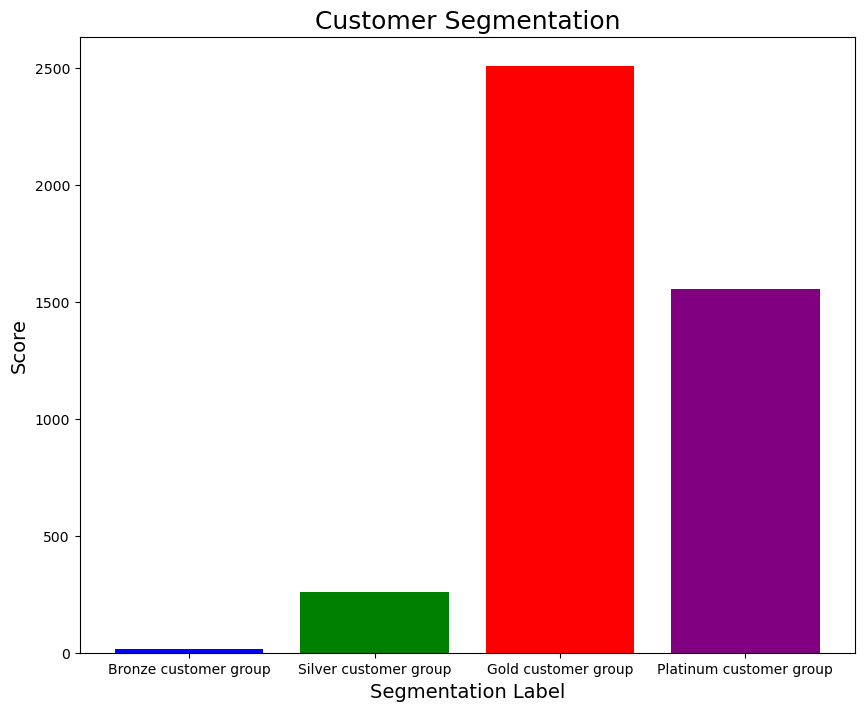

In [43]:
plt.figure(figsize = (10,8))
bar_colors = ['blue', 'green', 'red', 'purple']
plt.bar(rfm_group_bar_by_segment['Customer_segment_label'] , rfm_group_bar_by_segment['Count of customers'] , color = bar_colors)
plt.xlabel('Segmentation Label' , fontsize = 14)
plt.ylabel('Score' , fontsize = 14)
plt.title('Customer Segmentation' , fontsize = 18)
plt.show()


In [44]:
recency_group_bar = rfm_assigned_score.groupby('recency_label' )['CustomerID'].count()
recency_group_bar = pd.DataFrame(recency_group_bar)
recency_group_bar = recency_group_bar.rename(columns = {'CustomerID' : 'Count of customers'})
recency_group_bar= recency_group_bar.reset_index()


frequency_group_bar = rfm_assigned_score.groupby('frequency_label' )['CustomerID'].count()
frequency_group_bar = pd.DataFrame(frequency_group_bar)
frequency_group_bar = frequency_group_bar.rename(columns = {'CustomerID' : 'Count of customers'})
frequency_group_bar= frequency_group_bar.reset_index()


monetary_group_bar = rfm_assigned_score.groupby('monetary_label' )['CustomerID'].count()
monetary_group_bar = pd.DataFrame(monetary_group_bar)
monetary_group_bar = monetary_group_bar.rename(columns = {'CustomerID' : 'Count of customers'})
monetary_group_bar= monetary_group_bar.reset_index()


In [45]:
rfm_group_bar = rfm_assigned_score.groupby(['recency', 'frequency' , 'monetary'] )['CustomerID'].count()
rfm_group_bar = pd.DataFrame(rfm_group_bar)
rfm_group_bar = rfm_group_bar.rename(columns = {'CustomerID' : 'Count of customers'})
rfm_group_bar= rfm_group_bar.reset_index()

In [46]:
recency_group_bar

,recency_label,Count of customers
0,Lapsed customer,1079
1,Dormant customer,1083
2,Recent customer,1073
3,Most Recent customer,1103


In [47]:
frequency_group_bar

,frequency_label,Count of customers
0,Infrequent shoppers,1493
1,Occasional shoppers,835
2,Frequent shoppers,1138
3,Loyal shoppers,872


In [48]:
monetary_group_bar

,monetary_label,Count of customers
0,Marginal-value customer,30
1,Low-value customer,46
2,Medium-value customer,419
3,High-value customer,3843


In [49]:
rfm_group_bar

,recency,frequency,monetary,Count of customers
0,1,1,1,16
1,1,1,2,23
2,1,1,3,202
3,1,1,4,471
4,1,2,2,1
5,1,2,3,17
6,1,2,4,212
7,1,3,4,117
8,1,4,2,1
9,1,4,4,19


In [50]:
rfm_group_bar.describe()

,recency,frequency,monetary,Count of customers
count,42.000000,42.000000,42.000000,42.000000
mean,2.547619,2.071429,2.880952,103.285714
std,1.108776,1.045148,1.086556,141.826635
min,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,2.000000,2.250000
50%,3.000000,2.000000,3.000000,18.000000
75%,3.000000,3.000000,4.000000,198.750000
max,4.000000,4.000000,4.000000,523.000000


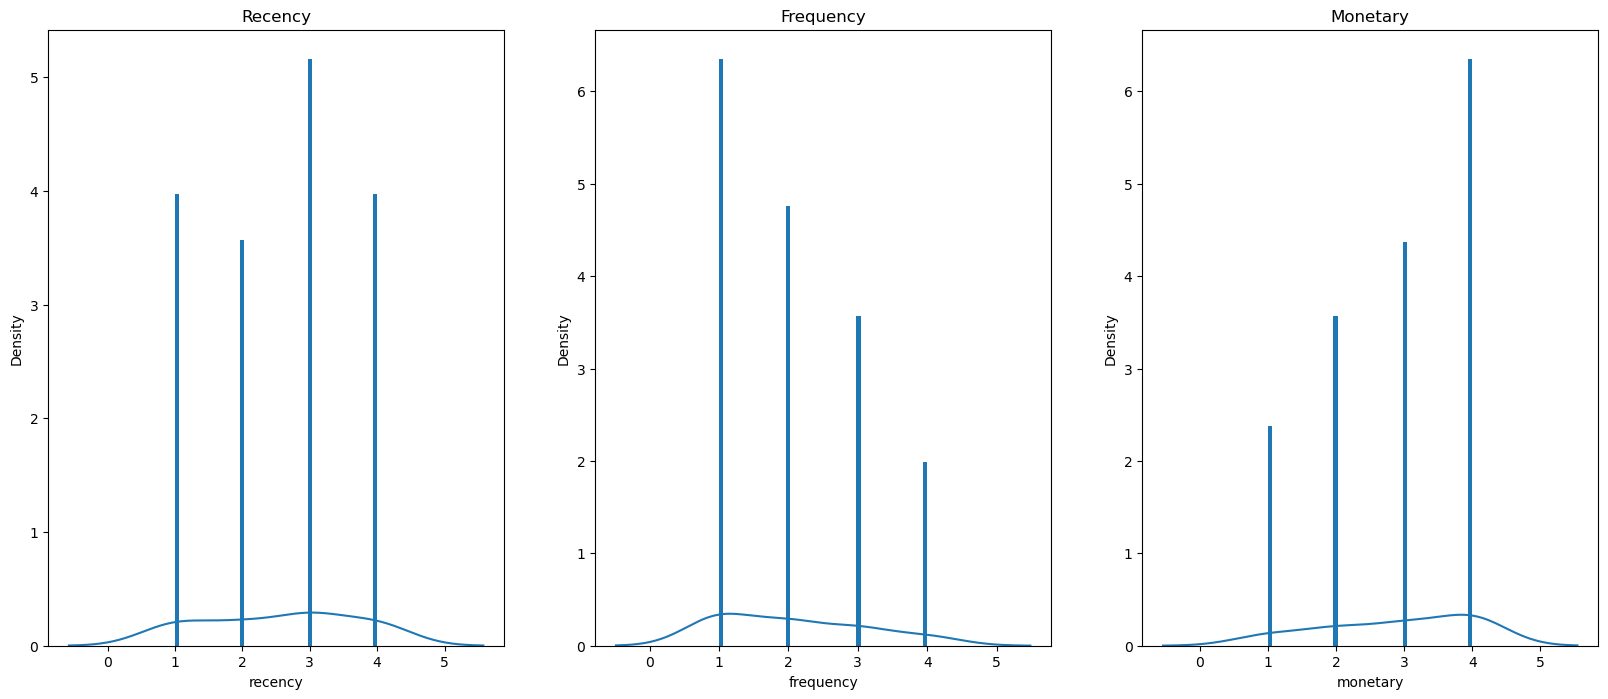

In [51]:
fig , ax = plt.subplots(1,3,figsize = (20,8))
pdc = sns.distplot(rfm_group_bar['recency'],
                  bins=50,
                  kde=True,
                  ax = ax[0],
                  hist_kws={"linewidth": 20,'alpha':1})
pdc = sns.distplot(rfm_group_bar['frequency'],
                  bins=50,
                  kde=True,
                  ax = ax[1],
                  hist_kws={"linewidth": 20,'alpha':1})
pdc = sns.distplot(rfm_group_bar['monetary'],
                  bins=50,
                  kde=True,
                  ax = ax[2],
                  hist_kws={"linewidth": 20,'alpha':1})
ax[0].set_title('Recency')
ax[1].set_title('Frequency')
ax[2].set_title('Monetary')

#pdc.set(xlabel='Normal Distribution', ylabel='Frequency')
 
plt.show()

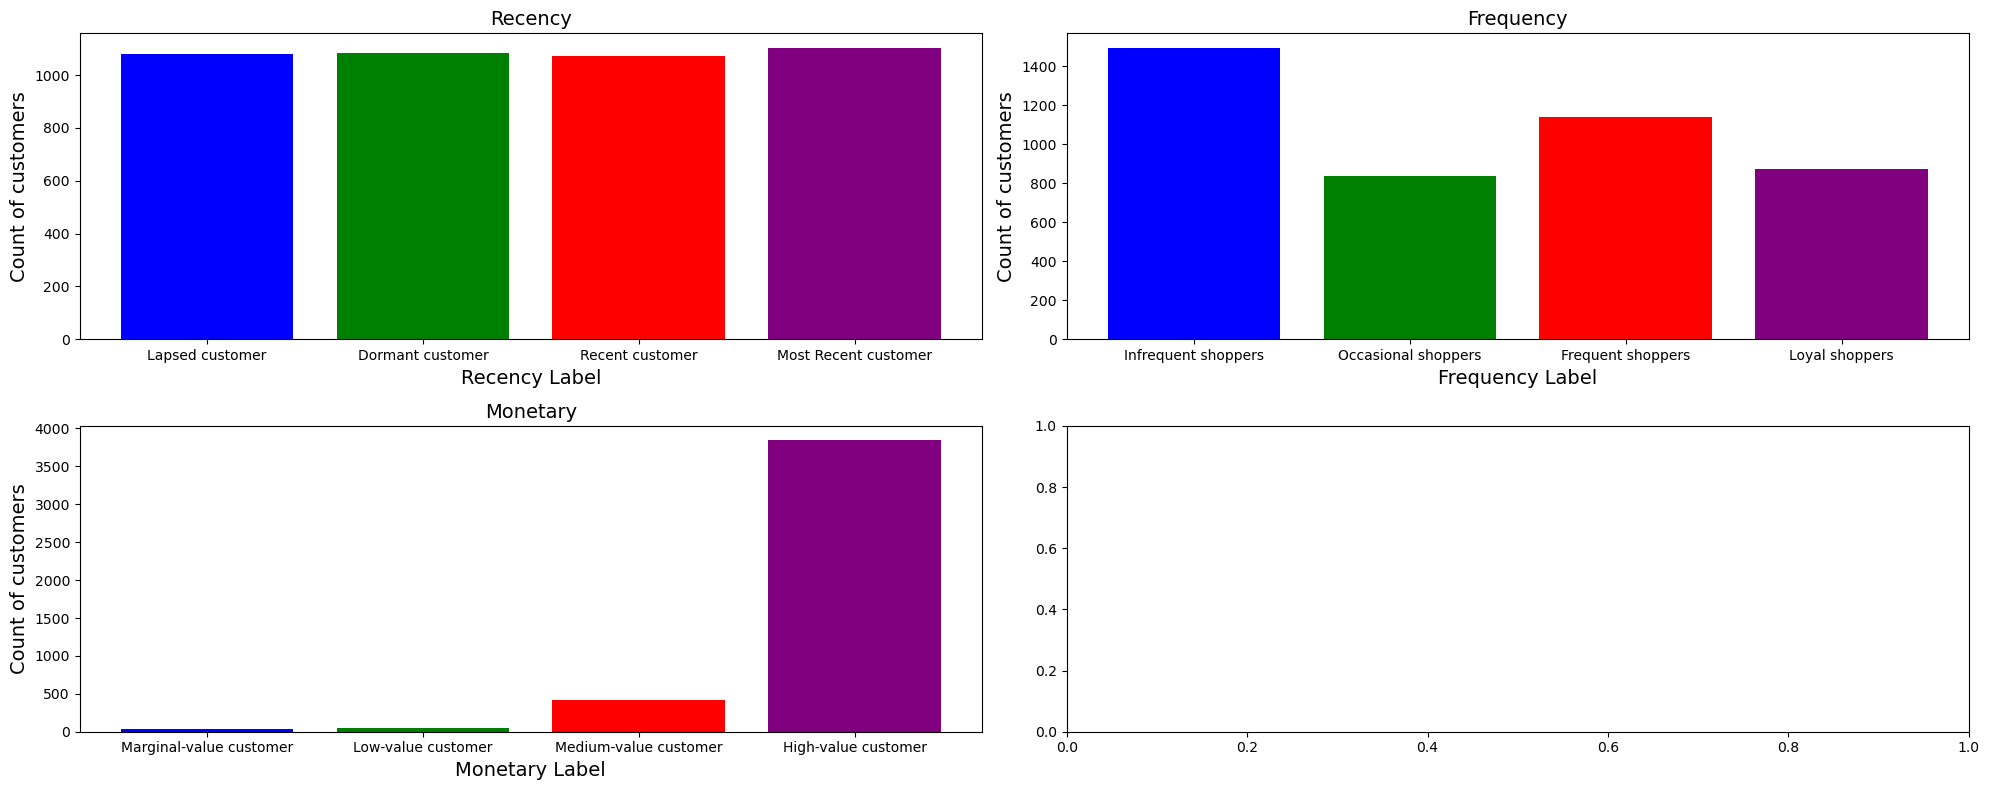

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(20, 8))

bar_colors = ['blue', 'green', 'red', 'purple']

# Plot the first subplot (Recency)
ax[0,0].bar(recency_group_bar['recency_label'], recency_group_bar['Count of customers'], color=bar_colors)
ax[0,0].set_xlabel('Recency Label' , fontsize = 14)  # Use set_xlabel, not xlabel
ax[0,0].set_ylabel('Count of customers' , fontsize =14)  # Use set_ylabel, not ylabel
ax[0,0].set_title('Recency' , fontsize =14)


ax[0,1].bar(frequency_group_bar['frequency_label'], frequency_group_bar['Count of customers'], color=bar_colors)
ax[0,1].set_xlabel('Frequency Label' , fontsize = 14)
ax[0,1].set_ylabel('Count of customers' , fontsize = 14)
ax[0,1].set_title('Frequency' , fontsize = 14)

ax[1,0].bar(monetary_group_bar['monetary_label'], monetary_group_bar['Count of customers'], color=bar_colors)
ax[1,0].set_xlabel('Monetary Label' , fontsize = 14)
ax[1,0].set_ylabel('Count of customers' , fontsize = 14)
ax[1,0].set_title('Monetary' , fontsize = 14)

# Show the figure with all subplots
plt.tight_layout()  
plt.show()

In [53]:

rfm_assigned_score 

,CustomerID,recency,frequency,monetary,recency_label,frequency_label,monetary_label,Score_assigned,Customer_segment_label
0,12346,1,1,4,Lapsed customer,Infrequent shoppers,High-value customer,15,Gold customer group
1,12347,4,4,4,Most Recent customer,Loyal shoppers,High-value customer,24,Platinum customer group
2,12348,2,3,4,Dormant customer,Frequent shoppers,High-value customer,20,Gold customer group
3,12349,3,1,4,Recent customer,Infrequent shoppers,High-value customer,17,Gold customer group
4,12350,1,1,4,Lapsed customer,Infrequent shoppers,High-value customer,15,Gold customer group
...,...,...,...,...,...,...,...,...,...
4333,18280,1,1,4,Lapsed customer,Infrequent shoppers,High-value customer,15,Gold customer group
4334,18281,1,1,3,Lapsed customer,Infrequent shoppers,Medium-value customer,12,Silver customer group
4335,18282,4,2,4,Most Recent customer,Occasional shoppers,High-value customer,20,Gold customer group
4336,18283,4,4,4,Most Recent customer,Loyal shoppers,High-value customer,24,Platinum customer group


In [54]:
rfm_assigned_score.to_csv('final_rfm.csv' , index=False)

In [55]:
rfm_df_unscaled_mod = rfm_df_unscaled.reset_index()
rfm_df_unscaled_mod

rfm_models = pd.merge(rfm_df_unscaled_mod , rfm_assigned_score , on = 'CustomerID')
rfm_models = rfm_models.drop(columns = ['recency_label' , 'frequency_label' , 'monetary_label'  , 'recency_y' , 'frequency_y' , 'monetary_y'])

rfm_models

,CustomerID,R,F,M,recency_x,frequency_x,monetary_x,Score_assigned,Customer_segment_label
0,12346,348,1,77183.60,1,1,4,15,Gold customer group
1,12347,25,7,4310.00,4,4,4,24,Platinum customer group
2,12348,98,4,1595.64,2,3,4,20,Gold customer group
3,12349,41,1,1757.55,3,1,4,17,Gold customer group
4,12350,333,1,334.40,1,1,4,15,Gold customer group
...,...,...,...,...,...,...,...,...,...
4333,18280,300,1,180.60,1,1,4,15,Gold customer group
4334,18281,203,1,80.82,1,1,3,12,Silver customer group
4335,18282,30,2,178.05,4,2,4,20,Gold customer group
4336,18283,26,16,1970.28,4,4,4,24,Platinum customer group


In [56]:
rfm_models.to_csv('rfm_final_model.csv' , index=False)

In [51]:
rfm_columns = ['R','F' ,'M' , 'recency_x' , 'frequency_x' , 'monetary_x' , 'Score_assigned']
rfm_scaler = MinMaxScaler()
rfm_models[rfm_columns] = rfm_scaler.fit_transform(rfm_models[rfm_columns])
rfm_model = rfm_models.drop(columns = ['CustomerID'] )
rfm_model

,R,F,M,recency_x,frequency_x,monetary_x,Score_assigned,Customer_segment_label
0,0.871314,0.000000,0.275443,0.000000,0.000000,1.000000,0.500000,Gold customer group
1,0.005362,0.028846,0.015368,1.000000,1.000000,1.000000,1.000000,Platinum customer group
2,0.201072,0.014423,0.005681,0.333333,0.666667,1.000000,0.777778,Gold customer group
3,0.048257,0.000000,0.006259,0.666667,0.000000,1.000000,0.611111,Gold customer group
4,0.831099,0.000000,0.001180,0.000000,0.000000,1.000000,0.500000,Gold customer group
...,...,...,...,...,...,...,...,...
4333,0.742627,0.000000,0.000631,0.000000,0.000000,1.000000,0.500000,Gold customer group
4334,0.482574,0.000000,0.000275,0.000000,0.000000,0.666667,0.333333,Silver customer group
4335,0.018767,0.004808,0.000622,1.000000,0.333333,1.000000,0.777778,Gold customer group
4336,0.008043,0.072115,0.007018,1.000000,1.000000,1.000000,1.000000,Platinum customer group


In [52]:
# Label encoding the customer segments
decode = LabelEncoder()
rfm_model['Customer_segment_label'] = decode.fit_transform(rfm_model['Customer_segment_label'])
rfm_model

,R,F,M,recency_x,frequency_x,monetary_x,Score_assigned,Customer_segment_label
0,0.871314,0.000000,0.275443,0.000000,0.000000,1.000000,0.500000,1
1,0.005362,0.028846,0.015368,1.000000,1.000000,1.000000,1.000000,2
2,0.201072,0.014423,0.005681,0.333333,0.666667,1.000000,0.777778,1
3,0.048257,0.000000,0.006259,0.666667,0.000000,1.000000,0.611111,1
4,0.831099,0.000000,0.001180,0.000000,0.000000,1.000000,0.500000,1
...,...,...,...,...,...,...,...,...
4333,0.742627,0.000000,0.000631,0.000000,0.000000,1.000000,0.500000,1
4334,0.482574,0.000000,0.000275,0.000000,0.000000,0.666667,0.333333,3
4335,0.018767,0.004808,0.000622,1.000000,0.333333,1.000000,0.777778,1
4336,0.008043,0.072115,0.007018,1.000000,1.000000,1.000000,1.000000,2


In [53]:
# Splitting the dataset for dependent variables and target variable
X = rfm_model.drop(['Customer_segment_label' ] , axis=1)
y = rfm_model['Customer_segment_label']


In [54]:
# Reshaping the dataset for dependent variables and target variable
X = np.asarray(X).reshape(-1,7)
y = np.asarray(y).reshape(-1,1)
X.shape , y.shape

((4338, 7), (4338, 1))

In [55]:
#Splitting the dataset for train-test split
X_train , X_test , y_train , y_test = train_test_split(X , y , stratify = y , test_size = 0.25 , random_state = 1)

In [56]:
X_train

array([[1.95710456e-01, 4.80769231e-03, 1.98053356e-03, ...,
        3.33333333e-01, 1.00000000e+00, 6.66666667e-01],
       [1.34048257e-02, 1.92307692e-02, 7.00069275e-03, ...,
        6.66666667e-01, 1.00000000e+00, 8.88888889e-01],
       [5.84450402e-01, 9.61538462e-03, 8.89678731e-04, ...,
        6.66666667e-01, 1.00000000e+00, 7.22222222e-01],
       ...,
       [3.32439678e-01, 0.00000000e+00, 1.32529262e-03, ...,
        0.00000000e+00, 1.00000000e+00, 5.55555556e-01],
       [7.56032172e-01, 0.00000000e+00, 5.65841240e-04, ...,
        0.00000000e+00, 6.66666667e-01, 3.33333333e-01],
       [5.14745308e-01, 0.00000000e+00, 4.83936122e-04, ...,
        0.00000000e+00, 6.66666667e-01, 3.33333333e-01]])

In [57]:
y_train

array([[1],
       [2],
       [1],
       ...,
       [1],
       [3],
       [3]])

In [58]:
X_test

array([[1.12600536e-01, 4.80769231e-03, 1.31708426e-03, ...,
        3.33333333e-01, 1.00000000e+00, 7.22222222e-01],
       [5.30831099e-01, 0.00000000e+00, 2.17021796e-03, ...,
        0.00000000e+00, 1.00000000e+00, 5.00000000e-01],
       [8.57908847e-02, 2.88461538e-02, 4.96205830e-03, ...,
        1.00000000e+00, 1.00000000e+00, 9.44444444e-01],
       ...,
       [3.56568365e-01, 0.00000000e+00, 8.48922459e-04, ...,
        0.00000000e+00, 1.00000000e+00, 5.55555556e-01],
       [4.02144772e-02, 1.92307692e-02, 6.30983468e-03, ...,
        6.66666667e-01, 1.00000000e+00, 8.88888889e-01],
       [7.53351206e-01, 0.00000000e+00, 7.92820130e-04, ...,
        0.00000000e+00, 1.00000000e+00, 5.00000000e-01]])

In [59]:

y_test

array([[1],
       [1],
       [2],
       ...,
       [1],
       [2],
       [1]])

In [60]:
#Hyerparameter tuning for random forest classifier
lg_model = LogisticRegression()
param_grid = {
               "C": [0.001, 0.01, 1.0],
               "penalty": ['l1' , 'l2'],
              "solver": ['liblinear', 'newton-cg', 'lbfgs' ],
              "max_iter": [50, 100, 150],
              "multi_class": ['ovr', 'multinomial']
}

In [61]:
lg_classifier = GridSearchCV(estimator = lg_model, param_grid = param_grid , cv=5 , scoring ='accuracy')



In [62]:
lg_classifier.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 1.0], 'max_iter': [50, 100, 150],
                         'multi_class': ['ovr', 'multinomial'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'newton-cg', 'lbfgs']},
             scoring='accuracy')

In [63]:
lg_classifier.cv_results_

{'mean_fit_time': array([0.00639582, 0.00079947, 0.00059981, 0.00604806, 0.05902305,
        0.02742572, 0.        , 0.00099888, 0.00059986, 0.00099969,
        0.03630915, 0.01562572, 0.00624909, 0.        , 0.        ,
        0.00719423, 0.05103626, 0.02042785, 0.00312524, 0.        ,
        0.        , 0.        , 0.05778279, 0.01958761, 0.0051971 ,
        0.00059996, 0.00099926, 0.00519567, 0.0515779 , 0.02523103,
        0.00059962, 0.        , 0.00100002, 0.00159817, 0.05241318,
        0.02274351, 0.02178659, 0.00099897, 0.00079918, 0.00776715,
        0.05606737, 0.02636671, 0.00099883, 0.00079923, 0.00039983,
        0.00099883, 0.05691295, 0.02609687, 0.02298532, 0.00040007,
        0.        , 0.009375  , 0.05516539, 0.02512212, 0.00119958,
        0.00079956, 0.00059977, 0.00119948, 0.04460177, 0.01874909,
        0.01875014, 0.        , 0.        , 0.01170278, 0.04815435,
        0.0274869 , 0.00199714, 0.00159831, 0.0010005 , 0.0017231 ,
        0.05302258, 0.02938251,

In [64]:
best_parameters = lg_classifier.best_params_

In [65]:
best_parameters
# C-values indicate the regularization strength. Smaller C values represent stronger regularization thereby significantly reducing overfitting of data.  
# L1 and L2 penalties are used to reduce overfitting of the data by discouraging complexity of the model and making them simpler, so that they can generalize accurately on the unseen data
# L1 penalty is used for high-dimensional dataset, L2- is the default penalty and is used when multicolinearity exists in the dataset
# newton-cg solver is suitable for multi-class classification and moderately sized datasets , lbfgs - high dimensional large datasets , Use 'liblinear' when you have a small to medium-sized dataset and want a good general-purpose solver. It works well for both L1 and L2 penalties.  
# Multinomial- More direct approach when dealing with multi-class classification and smaller datasets , OvR - When you are dealing with a binary classification algorithm that you want to use for multi-class problems and large datastes
# Max_iters estimates the number of times an algorithm needs to iterate before the algortihm stops irrespective of the convergence to reach an optimal solution
# Low values :  Convergence wont be reached resulting in suboptimal and inaccurate model
# High values : High max_iter value might lead to longer training times without substantial benefits in accuracy because the model's performace will become marginal after certain number of iterations

{'C': 1.0,
 'max_iter': 50,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [66]:
# Accuracy of the training dataset while tuning
accuracy_lg = lg_classifier.best_score_
print(f'Accuracy of the training set while tuning : {accuracy_lg*100}')

Accuracy of the training set while tuning : 99.04719366654851


In [67]:
model_lg = LogisticRegression(C = 1.0,
 max_iter = 50 ,
 multi_class = 'multinomial',
 penalty = 'l2',
 solver = 'newton-cg')

In [68]:
model_lg.fit(X_train , y_train)

LogisticRegression(max_iter=50, multi_class='multinomial', solver='newton-cg')

In [69]:
y_pred = model_lg.predict(X_test)

In [70]:
y_pred

array([1, 1, 2, ..., 1, 2, 1])

In [71]:
## Accuracy of the testing dataset while tuning
acc_lg = accuracy_score(y_test,y_pred)
print(f'Accuracy of the testing set while tuning : {acc_lg*100}')

Accuracy of the testing set while tuning : 99.44700460829493


In [72]:
# Cross validation techniques to verify the accuracy of model's performance
# K- Fold cross validation technique was employed
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [73]:
num_folds = 5

In [74]:
kf = KFold(n_splits = num_folds , shuffle = True , random_state =42)


In [75]:
clf = LogisticRegression()

In [76]:
scores = cross_val_score(clf,X,y,cv=kf)

In [77]:
## K-Fold cross validation accuracy scores
print("Cross-validation scores:" , scores)
print(f"Mean accuracy score: {scores.mean()}")

Cross-validation scores: [0.99308756 0.98963134 0.99193548 0.98385236 0.99077278]
Mean accuracy score: 0.9898559044111004


In [78]:
model_lg.classes_

array([0, 1, 2, 3])

In [79]:
evaluate_prediction = (0.482574,0.000000,0.000275,0.000000,0.000000,0.666667,0.333333)
numpy_evaluate_pred = np.asarray(evaluate_prediction).reshape(1,-1)
prediction = model_lg.predict(numpy_evaluate_pred)
prediction

array([3])

In [80]:
# Datset for prediction
rfm_df_unscaled_pred = rfm_df_unscaled.copy()
rfm_df_unscaled_pred = rfm_df_unscaled_pred.drop(columns=['recency' , 'frequency' , 'monetary'])
rfm_df_unscaled_pred

,R,F,M
CustomerID,,,
12346,348,1,77183.60
12347,25,7,4310.00
12348,98,4,1595.64
12349,41,1,1757.55
12350,333,1,334.40
...,...,...,...
18280,300,1,180.60
18281,203,1,80.82
18282,30,2,178.05


In [81]:
# Built a predicitve system for the machine learning algorithm using OOPS 
class Prediction:
    def __init__(self , num1, num2, num3):
        self.num1 = num1
        self.num2 = num2
        self.num3 = num3
        
    def pred_val_tb( self , num1 , num2 , num3):
        values_to_input = [num1,num2,num3]
        values_to_input = pd.DataFrame([values_to_input] , columns=['recency', 'frequency', 'monetary'])
        return values_to_input
        
    def quartiles_name_pred(self , val , quartile_name):
        rfm_df_unscaled_pred_mod = rfm_df_unscaled_pred.sort_values(by = [val] , ascending = True)
        rfm_df_unscaled_pred_mod

        quartile_1 = round((rfm_df_unscaled_pred_mod[val].count() + 1)/4 , 0).astype(int)
        quartile_2 = round((rfm_df_unscaled_pred_mod[val].count() + 1)/2 , 0).astype(int)
        quartile_3 = round(3*(rfm_df_unscaled_pred_mod[val].count() + 1)/4 , 0).astype(int)
        quartile_4 = (rfm_df_unscaled_pred_mod[val].count() - 1)

        dict_quartile = {}
        dict_quartile['Q1'] = quartile_1
        dict_quartile['Q2'] = quartile_2
        dict_quartile['Q3'] = quartile_3
        dict_quartile['Q4'] = quartile_4
        dict_quartile

        dict_pos = {}
        dict_pos['Q1'] = rfm_df_unscaled_pred_mod[val][quartile_1]
        dict_pos['Q2'] = rfm_df_unscaled_pred_mod[val][quartile_2]
        dict_pos['Q3'] = rfm_df_unscaled_pred_mod[val][quartile_3]
        dict_pos['Q4'] = rfm_df_unscaled_pred_mod[val][quartile_4]

        dict_pos

        index = [quartile_name]
        quartile_df = pd.DataFrame(dict_pos , index = index )
        quartile_df  = quartile_df .T
        quartile_df  = quartile_df .reset_index()
        return quartile_df 
  
    def rfm_quartile(self , a , b ):
        quartile_pred = self.quartiles_name_pred( a ,b )
        return quartile_pred
    
    def create_quartile_df(self):
        quartile_pred_tb = pd.merge(self.rfm_quartile('R' , 'recency') , self.rfm_quartile('F' , 'frequency') , on = 'index')
        quartiles_pred_tb = pd.merge(quartile_pred_tb , self.rfm_quartile('M' , 'monetary') , on = 'index')
        quartiles_pred_tb = quartiles_pred_tb.set_index('index')
        return quartiles_pred_tb
    
    def R_Score(r , q):
        if r <= q[0]:
            return 4
        elif r <= q[1]:
            return 3
        elif r <= q[2]:
            return 2
        else:
            return 1
        
    def FM_Score(r , q):
        if r <= q[0]:
            return 1
        elif r <= q[1]:
            return 2
        elif r <= q[2]:
            return 3
        else:
            return 4
        
    def calc_score(self, num1 , num2 , num3):
        values_to_input = self.pred_val_tb(num1 , num2 , num3)
        predict_quartile = self.create_quartile_df()
        r_score =  values_to_input['recency'].apply(lambda r: R_Score(r, predict_quartile['recency']))
        f_score = values_to_input['frequency'].apply(lambda r: FM_Score(r, predict_quartile['frequency']))
        m_score = values_to_input['monetary'].apply(lambda r: FM_Score(r, predict_quartile['monetary']))
        weight_recency = 1
        weight_frequency = 2 
        weight_monetary =  3
        score = (weight_recency*r_score + weight_frequency*f_score + weight_monetary*m_score)
        pred = [values_to_input['recency'][0],values_to_input['frequency'][0],values_to_input['monetary'][0], r_score[0],f_score[0],m_score[0],score[0]]
        pred = pd.DataFrame([pred] , columns = ['R','F','M','r_score' , 'f_score' , 'm_score' , 'score'])
        return pred
    
    def label_segment_predict(self, num1 , num2 , num3):
        evaluate_prediction = self.calc_score(num1 , num2 , num3)
        numpy_evaluate_pred = rfm_scaler.transform(evaluate_prediction.values.tolist()).reshape(1,-1)
        prediction = model_lg.predict(numpy_evaluate_pred)
        return prediction.item()
        
        
        
    

In [82]:
new_pred = Prediction(300,10,200)

In [83]:
segment_num = new_pred.label_segment_predict(300,10,200)
segment_num

0

In [84]:
if segment_num == 0:
    print('This customer belongs to the "Bronze Category"')
elif segment_num == 1:
    print('This customer belongs to the "Gold Category"')
elif segment_num == 2:
    print('This customer belongs to the "Platinum Category"')
elif segment_num == 3:
    print('This customer belongs to the "Silver Category"')

This customer belongs to the "Bronze Category"
